# TOKIO Dashboard Prototype

In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams.update({'font.size': 18})
import matplotlib.gridspec
import os

In [68]:
import pandas
import numpy as np
import scipy
import scipy.stats as stats
import json
import datetime
import time
import textwrap
import warnings

## Load and refine data

In [69]:
### Relative path to the repository's root directory
_REPO_BASE_DIR = os.path.join('..', '..')

### Translates cryptic counter names into something suitable for labeling plots
counter_labels = json.load(open(os.path.join(_REPO_BASE_DIR, 'scripts', 'counter_labels.json'), 'r'))

In [70]:
### black magic necessary for processing Mira log files :(
try:
    import pytz
    _USE_TZ = True
except ImportError:
    _USE_TZ = False

def utc_timestamp_to_YYYYMMDD( timestamp ):
    """
    This is a batty function that allows us to compare the UTC-based
    timestamps from Darshan logs (start_time and end_time) to the
    Chicago-based YYYY-MM-DD dates used to index the mmdf data.
    """
    if _USE_TZ:
        ### we know that these logs are from Chicago
        tz = pytz.timezone("America/Chicago")
        
        ### Darshan log's start time in UTC, so turn it into a datetime with UTC on it
        darshan_time = pytz.utc.localize(datetime.datetime.utcfromtimestamp(timestamp))
        
        ### Then convert this UTC start time into a local start time so
        ### we can compare it to the local mmdf timestamp
        darshan_time_at_argonne = darshan_time.astimezone(tz)
        return darshan_time_at_argonne
    else:
        ### we assume that this script is running on Argonne time; it's the best we can do
        warnings.warn("pytz is not available so mmdf data might be misaligned by a day!")
        return datetime.datetime.fromtimestamp(timestamp)

In [71]:
### Edison
df_edison = pandas.DataFrame.from_csv(os.path.join(_REPO_BASE_DIR,
                                                   'data',
                                                   'dat',
                                                   'tokio-lustre',
                                                   'edison-abc-stats_2-14_3-23.csv')).dropna()
df_edison['darshan_rw'] = [ 'write' if x == 1 else 'read' for x in df_edison['darshan_write_mode?'] ]
df_edison['darshan_file_mode'] = [ 'shared' if x in ['H5Part','MPIIO'] else 'fpp' for x in df_edison['darshan_api'] ]
df_edison.rename(columns={'lmt_bytes_covered': 'coverage_factor'}, inplace=True)
df_edison['system'] = "edison"
df_edison['iops_coverage_factor'] = -1.0

### Mira
df_mira = pandas.DataFrame.from_csv(os.path.join(_REPO_BASE_DIR,
                                                'data',
                                                'dat',
                                                'tokio-gpfs',
                                                'alcf-abc-stats_2-25_3-19.dat')).dropna()
rename_dict = { '# platform': "system" }
for key in df_mira.keys():
    if key == 'file_sys':
        rename_dict[key] = 'darshan_file_system'
    elif key not in rename_dict and not key.startswith('ggio_'):
        rename_dict[key] = 'darshan_' + key
df_mira.rename(columns=rename_dict, inplace=True)
df_mira['darshan_file_mode'] = [ 'shared' if x in ['H5Part','MPIIO'] else 'fpp' for x in df_mira['darshan_api'] ]
df_mira['coverage_factor'] = df_mira['darshan_total_bytes'] / (df_mira['ggio_bytes_read'] + df_mira['ggio_bytes_written'])
df_mira['iops_coverage_factor'] = (df_mira['darshan_total_rws'] / (df_mira['ggio_read_reqs'] + df_mira['ggio_write_reqs']))

In [72]:
df_mmdf = pandas.DataFrame.from_csv(os.path.join(_REPO_BASE_DIR,
                                                'data',
                                                'dat',
                                                'tokio-gpfs',
                                                'mira_mmdf_1-25_3-23.csv'),
                                        index_col=['file_system', 'date'])
df_mmdf['free_kib'] = df_mmdf['free_kib_blocks'] + df_mmdf['free_kib_frags']
df_mmdf['free_pct'] = df_mmdf['free_kib'] / df_mmdf['disk_size']

In [101]:
### I really hope iterrows behaves deterministically and preserves order...
new_data = {
    'mmdf_avg_fullness_pct': [],
    'mmdf_max_fullness_pct': [],
}

### iterate over each row of the master Mira dataframe
for row in df_mira.itertuples():
    fs_key = row.darshan_file_system
    mmdf_key = utc_timestamp_to_YYYYMMDD( row.darshan_start_time ).strftime("%Y-%m-%d")
    if mmdf_key in df_mmdf.loc[fs_key].index:
        ### only look at today's data
        df = df_mmdf.loc[fs_key].loc[mmdf_key]
        
        data_cols = [ True if x else False for x in df['data?'] ]

        ### calculate a percent fullness - don't bother saving the id of this fullest server though
        new_data['mmdf_max_fullness_pct'].append( 1.0 - df[ data_cols ]['free_pct'].min() )
        new_data['mmdf_avg_fullness_pct'].append( 1.0 - df[ data_cols ]['free_pct'].mean() )
    else:
        new_data['mmdf_max_fullness_pct'].append( np.nan )
        new_data['mmdf_avg_fullness_pct'].append( np.nan )

for new_col_name, new_col_data in new_data.iteritems():
    df_mira[new_col_name] = new_col_data

In [102]:
df = pandas.concat( (df_mira, df_edison) )

## Filter Data

In [103]:
df.drop(df.index[df['coverage_factor'] > 1.2], inplace=True)
# df.drop(df.index[df['iops_coverage_factor'] > 1.2], inplace=True)
df.drop(df.index[(df['system'] == 'mira') & (df['darshan_jobid'] == 1039807)], inplace=True)

## Define the dashboard view

Decide what to display on the dashboard by subselecting a specific view from the loaded data via `df_plot` and then populating the `row_plots` list with only those variables we want to display.

In [104]:
### Some rendering parameters for the dashboard itself
_DASHBOARD_FONT_SIZE = 12
_DASHBOARD_LINE_WIDTH = 1
_DASHBOARD_HIGHLIGHT_COLORS = [ '#DA0017', '#FD6A07', '#40A43A', '#2C69A9' ]
_DASHBOARD_LINE_COLOR = '#853692'

In [105]:
### Variables which we wish to display on the UMAMI
### dashboard.  Keyed by variables to display, and the values
### indicate if a high value is good
row_plots_master = { 
    'edison': [
        ('darshan_agg_perf_by_slowest_gibs', True),
        ('coverage_factor',                  True),
        ('lmt_mds_ave',                      False),
        ('lmt_ops_opencloses',               False),
        ('lmt_oss_ave',                      False),
        ('ost_avg_pct',                      False),
        ('ost_bad_pct',                      False),
        ('job_max_radius',                   False),
        ('job_concurrent_jobs',              False),
    ],
    'mira': [
        ('darshan_agg_perf_by_slowest_gibs', True),
        ('coverage_factor',                  True),
        ('iops_coverage_factor',             True),
        ('ggio_ops_opencloses',              False),
        ('ggio_ops_rw',                      False),
        ('ggio_read_dirs',                   False),
    ],
}

In [106]:
def umami_filter(df, file_system, app, rw, other_filters=None):
    """
    Translates a few basic logical input parameters into a filtered dataframe
    """
    filter_list = []
    if file_system is not None:
        filter_list.append((df['darshan_file_system'] == file_system))
    if app is not None:
        filter_list.append((df['darshan_app'] == app))
    if rw is not None:
        filter_list.append((df["darshan_rw"] == rw))

    if other_filters is not None:
        filter_list = filter_list + other_filters
    ### Apply filters to cut down on the data we're going to present
    num_rows = len(df)
    print "Start with %d rows before filtering" % num_rows
    net_filter = [ True for i in range(len(df.index))]
    for idx, condition in enumerate(filter_list):
        ct = len( [ x for x in net_filter if x ] )
        net_filter &= condition
        num_drops = (ct - len( [ x for x in net_filter if x ] ))
        print "Dropped %d rows after filter #%d (%d left)" % (num_drops, idx, ct-num_drops)

    print "%d rows will be included in UMAMI" % len(df[net_filter].index)
    assert len(df[net_filter].index) > 0
    
    return df[net_filter].copy()

In [107]:
### Specify the type of job we wish to track
TARGET_FILE_SYSTEM = 'scratch3'
TARGET_APP = 'VPIC-IO'
TARGET_RW = 'write'
other_filters = [
#    (df['darshan_end_time'] >= time.mktime(datetime.datetime(2017,  2, 25,  0,  0,  0).timetuple())),
#    (df['darshan_end_time'] <= time.mktime(datetime.datetime(2017,  3,  3, 12,  0,  0).timetuple())),
]

In [108]:
### Specify the type of job we wish to track
TARGET_FILE_SYSTEM = 'mira-fs1'
TARGET_APP = 'VPIC-IO'
TARGET_RW = 'write'
other_filters = [
     (df['darshan_end_time'] >= time.mktime(datetime.datetime(2017,  3,  1,  0,  0,  0).timetuple())),
     (df['darshan_end_time'] <= time.mktime(datetime.datetime(2017,  3, 12,  0,  0,  0).timetuple())),
]

In [119]:
### Specify the type of job we wish to track
TARGET_FILE_SYSTEM = 'mira-fs1'
TARGET_APP = 'BD-CATS-IO'
TARGET_RW = 'read'
other_filters = [
     (df['darshan_end_time'] >= time.mktime(datetime.datetime(2016,  3,  4, 12,  0,  0).timetuple())),
     (df['darshan_end_time'] <= time.mktime(datetime.datetime(2018,  3,  7,  0,  0,  0).timetuple())),
]

In [120]:
### Apply the filters we defined above to get a dataframe suitable for UMAMI
df_plot = umami_filter(df, TARGET_FILE_SYSTEM, TARGET_APP, TARGET_RW, other_filters)
row_plots = row_plots_master['mira' if 'mira' in TARGET_FILE_SYSTEM else 'edison']

Start with 1130 rows before filtering
Dropped 1038 rows after filter #0 (92 left)
Dropped 83 rows after filter #1 (9 left)
Dropped 0 rows after filter #2 (9 left)
Dropped 0 rows after filter #3 (9 left)
Dropped 0 rows after filter #4 (9 left)
9 rows will be included in UMAMI


Once the correct input view and outputs are defined, make a copy of the data that we manipulate to get the data into a plottable form.

In [121]:
df_plot['darshan_agg_perf_by_slowest_gibs'] = df_plot['darshan_agg_perf_by_slowest'] / 1024.0
df_plot['lmt_ops_opencloses'] = df_plot['lmt_ops_opens'] + df_plot['lmt_ops_closes']
df_plot['ggio_ops_opencloses'] = df_plot['ggio_opens'] + df_plot['ggio_closes']
df_plot['ggio_ops_rw'] = df_plot['ggio_read_reqs'] + df_plot['ggio_write_reqs']

In [122]:
### Can also just add up all the MDS ops (of interest).
### Even though they are not weighted evenly in terms
### of cost on MDS, this is a rough approximation of
### activity since metadata rates are also bursty and
### probably don't overlap often.
for i in df_plot.keys():
    if "_ops_" in i:
        if "lmt_ops_total" in df_plot:
            df_plot['lmt_ops_total'] += df_plot[i]
        else:
            df_plot['lmt_ops_total'] = df_plot[i]
counter_labels['lmt_ops_total'] = "Server Metadata Ops"
counter_labels['lmt_ops_opencloses'] = "Server Open/Close Ops"
counter_labels['ggio_ops_opencloses'] = "Server Open/Close/Creat Ops"
counter_labels['ggio_ops_rw'] = "Server Read/Write Ops"

### Scale op counts to make them plottable:
for i in df_plot.keys():
    if "_ops_" in i or i == "ggio_read_dirs":
        max_val = df_plot[i].max()
        if max_val > 2e9:
            df_plot[i] = df_plot[i] / 1e9
            counter_labels[i] += " (GOps)"
        elif max_val > 2e6:
            df_plot[i] = df_plot[i] / 1e6
            counter_labels[i] += " (MOps)"
        elif max_val > 2e3:
            df_plot[i] = df_plot[i] / 1e3
            counter_labels[i] += " (KOps)"

Now actually generate the dashboard diagram.

Saved umami-mira-fs1-bd-cats-read.pdf


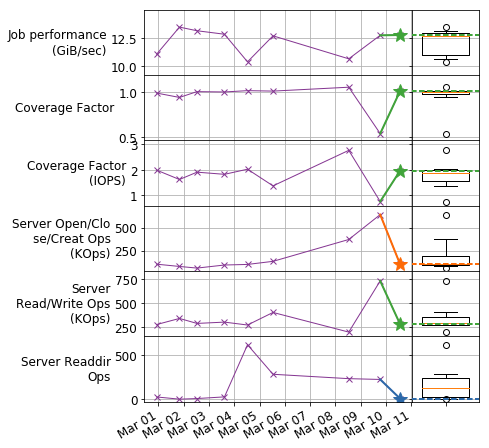

In [123]:
fig = plt.figure()
fig.set_size_inches(6, len(row_plots) * 12 / 9)

### Required to adjust the column widths of our figure (width_ratios)
gridspec = matplotlib.gridspec.GridSpec(len(row_plots), 2, width_ratios=[4,1])

last_ax_ts = None
for idx, (plot_variable, big_is_good) in enumerate(row_plots):
    def dt64todatetime(dt64):
        """
        the dataframe stores datetimes as np.datetime64,
        which is expressed in nanoseconds (1e9 seconds).  To
        convert this to a datetime.datetime object which we
        can transform in matplotlib, some amount of
        gymnastics is required.
        """
        return datetime.datetime.fromtimestamp(dt64.astype(int) * 1e-9)
    
    ### Cast all pandas times (numpy.datetime64) into Python datetimes
    x = [ datetime.datetime.fromtimestamp(x) for x in df_plot['darshan_end_time'].values ]
    y = df_plot[plot_variable].values

    ### first plot the timeseries of the given variable
    ax_ts = fig.add_subplot(gridspec[2*idx])
    ax_ts.plot(x, y,
               linestyle='-',
               marker='x',
               linewidth=_DASHBOARD_LINE_WIDTH * 1.0,
               color=_DASHBOARD_LINE_COLOR)

    # textwrap.wrap inserts line breaks into each label
    ax_ts.set_ylabel('\n'.join(textwrap.wrap(
                        text=counter_labels.get(plot_variable, plot_variable),
                        width=15)),
                        fontsize=_DASHBOARD_FONT_SIZE,
                        rotation=0,
                        horizontalalignment='right',
                        verticalalignment='center'
                    )
    ax_ts.grid()

    # blank out the labels for all subplots except the bottom-most one
    if idx != len(row_plots) - 1:
        ax_ts.set_xticklabels([])
    else:
        last_ax_ts = ax_ts
        # resize and rotate the labels for the timeseries plot
        for tick in ax_ts.xaxis.get_major_ticks():
            tick.label.set_fontsize(_DASHBOARD_FONT_SIZE) 
            tick.label.set_rotation(45)

    # also adjust the font size for the y labels
    for tick in ax_ts.yaxis.get_major_ticks():
        tick.label.set_fontsize(_DASHBOARD_FONT_SIZE)

    ### then plot the boxplot summary of the given variable
    ax_box = fig.add_subplot(gridspec[2*idx+1])
    boxp = ax_box.boxplot(y[0:-1], ### note: do not include last measurement in boxplot
                   widths=0.70,
                   boxprops={'linewidth':_DASHBOARD_LINE_WIDTH},
                   medianprops={'linewidth':_DASHBOARD_LINE_WIDTH},
                   whiskerprops={'linewidth':_DASHBOARD_LINE_WIDTH},
                   capprops={'linewidth':_DASHBOARD_LINE_WIDTH},
                   flierprops={'linewidth':_DASHBOARD_LINE_WIDTH},
                   whis=[5,95])
    
    # scale the extents of the y ranges a little for clarity
    ax_ts.set_ylim(map(lambda a, b: a*(1 + b), ax_ts.get_ylim(), (-0.1, 0.1)))
    
    # lock in the y range to match the timeseries plot, just in case
    ax_box.set_ylim(ax_ts.get_ylim())

    # determine the color of our highlights based on quartile
    percentiles = [ np.percentile(y[0:-1], percentile) for percentile in 25, 50, 75, 100 ]
    for color_index, percentile in enumerate(percentiles):
        if y[-1] <= percentile:
            break
    if big_is_good:
        highlight_color = _DASHBOARD_HIGHLIGHT_COLORS[color_index]
    else:
        highlight_color = _DASHBOARD_HIGHLIGHT_COLORS[(1+color_index)*-1]
                                        
    # highlight the latest measurement on the timeseries plot
    x_last = matplotlib.dates.date2num(x[-1])
    x_2nd_last = matplotlib.dates.date2num(x[-2])
    ax_ts.plot([x_2nd_last, x_last],
               [y[-2], y[-1]],
               linestyle='-',
               color=highlight_color,
               linewidth=_DASHBOARD_LINE_WIDTH * 2.0)
    ax_ts.plot([x_last], [y[-1]],
               marker='*',
               color=highlight_color,
               markersize=15)

    # where does this last data point lie on the distribution?
    ax_box.plot([0,2], [y[-1],y[-1]], linestyle='--', color=highlight_color, linewidth=2.0, zorder=10)

    # blank out all labels
    ax_box.set_yticklabels([""])
    ax_box.set_xticklabels([""])
    ax_box.yaxis.grid()

fig.subplots_adjust(hspace=0.0, wspace=0.0)
fig.autofmt_xdate()
last_ax_ts.xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%b %d'))

output_file = "umami-%s-%s-%s.pdf" % ( TARGET_FILE_SYSTEM, TARGET_APP.replace('-IO', '').lower(), TARGET_RW )
fig.savefig(output_file, bbox_inches="tight")
print "Saved %s" % output_file